Loading data.

In [1]:
library(ggplot2)
library(scales)
library(tidyr)
options(repr.plot.width=5, repr.plot.height=4)
data = read.csv("cset_data.csv")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Setting cutoff at 2020 because 2021 data is incomplete.

In [2]:
to2020 = data[data$date<=2020,]

## Model 1: Basic Linear

In [3]:
lin.model = lm( quant ~ date, data=to2020 )

summary( lin.model )

lin.pred = data.frame( date=to2020$date )
new.dates = data.frame( date=c(2020, 2021, 2022) )
lin.pred = rbind( lin.pred, new.dates )

lin.pred$quant = predict( lin.model, newdata=lin.pred )
lin.pred[c("quant", "lwr90", "upr90")] = predict( lin.model, newdata=lin.pred, interval = "prediction", level = 0.90 )
lin.pred[c("quant", "lwr70", "upr70")] = predict( lin.model, newdata=lin.pred, interval = "prediction", level = 0.70 )
lin.pred[c("quant", "lwr50", "upr50")] = predict( lin.model, newdata=lin.pred, interval = "prediction", level = 0.50 )


Call:
lm(formula = quant ~ date, data = to2020)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0049185 -0.0021249 -0.0001496  0.0026330  0.0041754 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.062e+01  6.446e-01  -31.99 1.40e-10 ***
date         1.029e-02  3.199e-04   32.16 1.34e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003355 on 9 degrees of freedom
Multiple R-squared:  0.9914,	Adjusted R-squared:  0.9904 
F-statistic:  1034 on 1 and 9 DF,  p-value: 1.337e-10


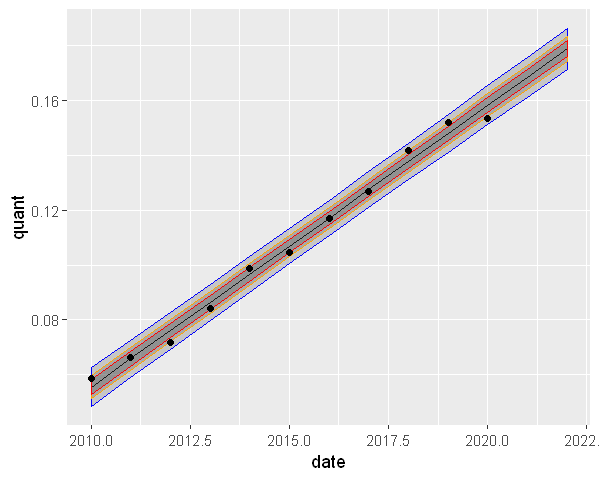

In [4]:
ggplot(data=lin.pred, aes(date, quant)) + 
geom_line() +
geom_ribbon(aes(ymin=lwr90, ymax=upr90), color="blue", alpha=0.2) +
geom_ribbon(aes(ymin=lwr70, ymax=upr70), color="orange", alpha=0.2) +
geom_ribbon(aes(ymin=lwr50, ymax=upr50), color="red", alpha=0.2) +
geom_point(data=to2020, aes(date, quant))

## Model 2: Exponential

Assumption made in this model is that the number of US-China collaborations is growing at an exponential rate and the US AI papers which are not collaborations with China are also growing at an exponential rate.

$$
\begin{split}
\text{ quant } & = \frac{ \exp ( A \text{ date } ) }{ \exp( A \text{ date } ) + \exp ( B \text{ date } )} \\
& \Rightarrow \text{ date }  \propto \log \Big( \frac{ 1 }{ \text{quant} } - 1 \Big) 
\end{split}
$$

In [5]:
expon.model = lm( log( 1 / quant - 1 ) ~ date, data=to2020 )

summary( expon.model )

expon.pred = data.frame( date=to2020$date )
new.dates = data.frame( date=c(2020, 2021, 2022) )
expon.pred = rbind( expon.pred, new.dates )

expon.pred$quant = 1 / ( exp( predict( expon.model, newdata=expon.pred ) ) + 1 )

expon.pred[c("quant", "lwr90", "upr90")] = 1 / ( exp( predict( expon.model, newdata=expon.pred, interval = "prediction", level = 0.90 ) ) + 1 )
expon.pred[c("quant", "lwr70", "upr70")] = 1 / ( exp( predict( expon.model, newdata=expon.pred, interval = "prediction", level = 0.70 ) ) + 1 )
expon.pred[c("quant", "lwr50", "upr50")] = 1 / ( exp( predict( expon.model, newdata=expon.pred, interval = "prediction", level = 0.50 ) ) + 1 )


Call:
lm(formula = log(1/quant - 1) ~ date, data = to2020)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.07263 -0.03033 -0.01206  0.02830  0.10065 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 229.930279   9.802691   23.46 2.22e-09 ***
date         -0.113031   0.004865  -23.23 2.41e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05102 on 9 degrees of freedom
Multiple R-squared:  0.9836,	Adjusted R-squared:  0.9818 
F-statistic: 539.8 on 1 and 9 DF,  p-value: 2.412e-09


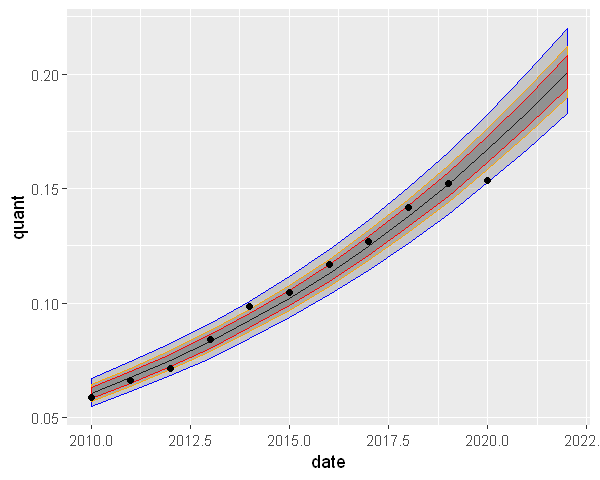

In [6]:
ggplot(data=expon.pred, aes(date, quant)) + 
geom_line() +
geom_ribbon(aes(ymin=lwr90, ymax=upr90), color="blue", alpha=0.2) +
geom_ribbon(aes(ymin=lwr70, ymax=upr70), color="orange", alpha=0.2) +
geom_ribbon(aes(ymin=lwr50, ymax=upr50), color="red", alpha=0.2) +
geom_point(data=to2020, aes(date, quant))

### Testing asumptions:
1. How well is the US-China collaboration count fit by an exponential?

$R^2$.

In [7]:
summary( lm( log(us_china_collabs) ~ date, data=to2020 ) )$r.squared

[1] 0.9925545

Plot.

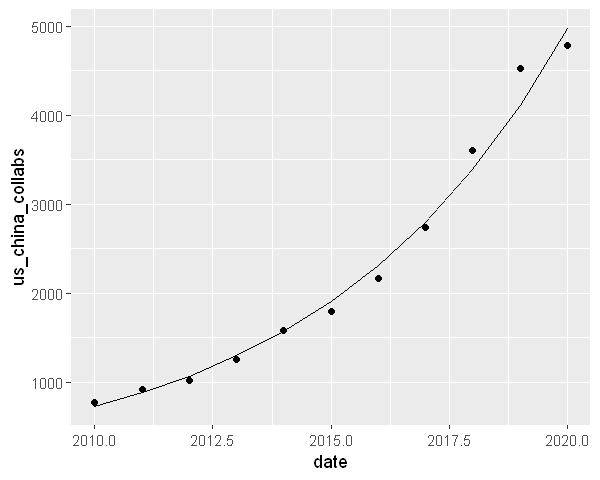

In [8]:
model.points = data.frame(date=to2020$date)
model.points$quant = exp( predict( lm( log(us_china_collabs) ~ date, data=to2020 ) ) )
ggplot( data=to2020, aes( date, us_china_collabs ) ) + 
geom_point() +
geom_line(data=model.points, aes(date, quant))

2. How well are the non US-China papers fit by an exponential?

$R^2$.

In [9]:
summary( lm( log(total - us_china_collabs) ~ date, data=to2020 ) )$r.squared

[1] 0.9301489

Plot.

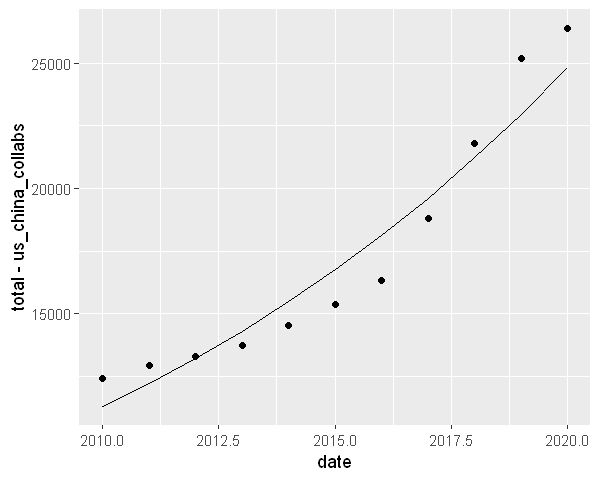

In [10]:
model.points = data.frame(date=to2020$date)
model.points$quant = exp( predict( lm( log(total - us_china_collabs) ~ date, data=to2020 ) ) )
ggplot( data=to2020, aes( date, total - us_china_collabs ) ) + 
geom_point() +
geom_line(data=model.points, aes(date, quant))